## Setup

In [84]:
import sys
import math
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def load_data(dataset_name):
    # Read the data and create the dataframe.
    df = pd.DataFrame(pd.read_csv(dataset_name, encoding='utf-8', sep=",", skiprows = 1, header=None))

    # Specify column names.
    df.columns = ['day', 'isweekend', 'weekday', 'periodofday', 'nr_bookings_period', 'weather', 'calls_period']

    # Convert the 'timestamp' column to date format.
    df['day'] = pd.to_datetime(df['day'], errors="raise")

    df.drop('calls_period', axis=1, inplace=True)
    
    df.dropna(inplace=True)

    return df.sort_values('day')


In [85]:
df = load_data("data/VancouverFullPreprocessed.csv")

In [86]:
df.head()

,day,isweekend,weekday,periodofday,nr_bookings_period,weather
0,2017-09-07 00:00:00+00:00,False,Thu,1,235,36
1,2017-09-07 00:00:00+00:00,False,Thu,2,954,36
2,2017-09-07 00:00:00+00:00,False,Thu,3,702,36
3,2017-09-07 00:00:00+00:00,False,Thu,4,729,36
4,2017-09-07 00:00:00+00:00,False,Thu,5,1183,36


## Data Preparation

In [87]:
# Convert weather to an integer identifier.
df['weather'] = df['weather'].apply(lambda x: int(x))

# Convert timestamp to an integer identifier of the day.
df['day_int'] = df['day'].apply(lambda x: x.toordinal())

# Extract day of the week and hour of the day.
df['dayofweek'] = df['day'].apply(lambda x: x.isoweekday())
df['hourofday'] = df['day'].apply(lambda x: x.hour)
df.drop('day', axis=1, inplace=True)

In [88]:
df.head()

,isweekend,weekday,periodofday,nr_bookings_period,weather,day_int,dayofweek,hourofday
0,False,Thu,1,235,36,736579,4,0
1,False,Thu,2,954,36,736579,4,0
2,False,Thu,3,702,36,736579,4,0
3,False,Thu,4,729,36,736579,4,0
4,False,Thu,5,1183,36,736579,4,0


In [89]:
# Fill out days and periods that do not appear in our data as having zero bookings.

from datetime import date

min_day = int(min(list(df['day_int'])))
max_day = int(max(list(df['day_int'])))
days = set(range(min_day, max_day + 1))
days_with_obs = set(df['day_int'])
missing_days = days - days_with_obs
new_rows = []
for day in missing_days:
    for i in range(23):
        row_data = {'day_int': day, 'dayofweek': date.fromordinal(day).isoweekday(), 'hourofday': i, 'periodofday': i % 3, 'nr_bookings_period': 1, 'weekday': 'Mon', 'weather': 0}
        new_rows.append(row_data)

new_df = pd.DataFrame(new_rows, columns = ['day_int', 'dayofweek', 'hourofday', 'periodofday', 'weekday', 'weather', 'nr_bookings_period'])
df = df.append(new_df, ignore_index=True, sort=True)
df.sort_values(['day_int', 'hourofday', 'periodofday'], inplace=True, ascending=True)

In [90]:
df.head()

,day_int,dayofweek,hourofday,isweekend,nr_bookings_period,periodofday,weather,weekday
0,736579,4,0,False,235,1,36,Thu
1,736579,4,0,False,954,2,36,Thu
2,736579,4,0,False,702,3,36,Thu
3,736579,4,0,False,729,4,36,Thu
4,736579,4,0,False,1183,5,36,Thu


In [91]:
# One-hot encode categorical columns.
def one_hot_column(df, column_name):
    dummies = pd.get_dummies(df[column_name]).values.tolist()
    df.drop(column_name, axis=1, inplace=True)
    df[column_name] = dummies
    return df

df = one_hot_column(df, 'dayofweek')
df = one_hot_column(df, 'periodofday')
df = one_hot_column(df, 'weather')

In [92]:
# Number of days.
print(len(set(df['day_int'])))

54


In [93]:
# Divide the dataset into train and test sets.
# Last week of data is for testing.
max_day = max(df['day_int'].tolist())
df_train = df[df['day_int'] <= max_day - 26]
df_test = df[df['day_int'] > max_day - 26]

In [94]:
df_train.head()

,day_int,hourofday,isweekend,nr_bookings_period,weekday,dayofweek,periodofday,weather
0,736579,0,False,235,Thu,"[0, 0, 0, 1, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
1,736579,0,False,954,Thu,"[0, 0, 0, 1, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
2,736579,0,False,702,Thu,"[0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
3,736579,0,False,729,Thu,"[0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
4,736579,0,False,1183,Thu,"[0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"


In [95]:
print(len(df_train), len(df_test))

276 182


In [96]:
df_train = df_train.drop(columns=['isweekend', 'weekday', 'day_int', 'hourofday'])
df_train.head()

,nr_bookings_period,dayofweek,periodofday,weather
0,235,"[0, 0, 0, 1, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
1,954,"[0, 0, 0, 1, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
2,702,"[0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
3,729,"[0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
4,1183,"[0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"


In [97]:
df_test = df_test.drop(columns=['isweekend', 'weekday', 'day_int', 'hourofday'])
df_test.head()

,nr_bookings_period,dayofweek,periodofday,weather
161,249,"[0, 0, 0, 1, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
162,959,"[0, 0, 0, 1, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
163,666,"[0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
164,717,"[0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
165,1233,"[0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 1, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [98]:
print(len(df_train), len(df_test))

276 182


In [99]:
# WARNING: This was the previous implementation of the function that
# generates the data in the correct format for the models.
# However, the way I first implemented it, it was including the
# variable we wanted to predict in the set of features used for prediction.
# Below you will find a correct version of this function.
# I kept the wrong implementation here in case someone wants to check that
# it indeed produced the results I reported in the slides.
def to_sequence_wrong(df):
    x = []
    y = [] 
    observations = []
    for _, row in df.iterrows():
        observations.append([row['nr_bookings_period']] + row['dayofweek'] + row['periodofday'] + row['weather'])
    for j in range(len(observations)):
        window = [observations[j]]
        window = [x for x in window]
        x.append(window)
        y.append(window[0][0])
    return np.array(x), np.array(y)

In [100]:
def to_sequence(df):
    x = []
    y = [] 
    observations = []
    for _, row in df.iterrows():
        observations.append([row['nr_bookings_period']] + row['dayofweek'] + row['periodofday'] + row['weather'])
    for j in range(len(observations)):
        window = [observations[j]]
        y.append(window[0][0])
        window = [x[1:] for x in window]
        x.append(window)
        
    return np.array(x), np.array(y)


In [101]:
x_train, y_train = to_sequence(df_train)
x_test, y_test = to_sequence(df_test)

In [102]:
print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

Shape of training set: (276, 1, 31)
Shape of test set: (182, 1, 31)


In [103]:
# Print a pair features (x_train) and corresponding number of bookings (y_train)
print(x_train[0], y_train[0])

[[0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]] 235


In [104]:
# Print a pair features (x_test) and corresponding number of bookings (y_test)
print(x_test[0], y_test[0])

[[0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]] 249


In [105]:
print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

x_train = x_train.reshape((x_train.shape[0], 31))
x_test = x_test.reshape((x_test.shape[0], 31))

print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

Shape of training set: (276, 1, 31)
Shape of test set: (182, 1, 31)
Shape of training set: (276, 31)
Shape of test set: (182, 31)


In [112]:
# Standard ML Models for comparison
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

# Splitting data into training/testing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Auto ARIMA model
import pmdarima as pm

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

# Distributions
import scipy
from collections import defaultdict


def evaluate(x_train, x_test, y_train, y_test):
    # Instantiate the models
    linear_regression = LinearRegression(fit_intercept=False)
    elastic_net = ElasticNet(alpha=1.0, l1_ratio=0.5)
    random_forest = RandomForestRegressor(n_estimators=50)
    extra_trees = ExtraTreesRegressor(n_estimators=50)
    svr = SVR(kernel='rbf', degree=3, C=1.0, gamma='auto')
    gradient_boosting = GradientBoostingRegressor(n_estimators=20)
    arima_train = np.array([[float(item[0])] for item in x_train])  
    arima = pm.auto_arima([x for x in arima_train], start_p=0, start_q=0, max_p=2, max_q=2, m=7,
                             start_P=0, max_P=2, seasonal=True, d=0, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

    model_name_list = ['Linear Regression', 'ElasticNet Regression', 'Random Forest', 'Extra Trees', 'SVM', 'Gradient Boosted', 'ARIMA', 'Baseline']
    models_list = [linear_regression, elastic_net, random_forest, extra_trees, svr, gradient_boosting, arima]
    evaluation_results = {name:{'predictions':[], 'actual_values':[]} for name in model_name_list}

    # Mean value: baseline metric
    evaluation_results['Baseline']['predictions'].extend([np.mean(y_train)] * len(y_test))
    evaluation_results['Baseline']['actual_values'].extend(y_test)
    
    # Train and predict with each model
    for i, row in enumerate(y_test):
        print("Evaluating row {}/{}".format(i + 1, len(y_test)))
        for j, model in enumerate(models_list):
            # Train the model and test it in the next row of the test set.
            if j == len(models_list) - 1: # The ARIMA model is tested in a different way.
                model = model.fit(x = [x for x in arima_train], y = y_train)
                yhat = model.predict(n_periods = 7)[0]
                model.update(y_test[i], max_iter = 7)
            else:
                model = model.fit(x_train, y_train)
                yhat = model.predict(x_test[i].reshape(1, -1))

            # Keep track of predictions versus actual values
            evaluation_results[model_name_list[j]]['predictions'].append(yhat)
            evaluation_results[model_name_list[j]]['actual_values'].append(y_test[i])
        
        # Add current row to the training set.
        x_train = np.vstack((x_train, x_test[i]))
        y_train = np.append(y_train, y_test[i])
        
        # The training set of the ARIMA model does not have all the features.
        arima_train = np.vstack((arima_train, [x_test[i][0]]))
    

    return evaluation_results


In [113]:
results = evaluate(x_train, x_test, y_train, y_test)

Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 1, 7); AIC=255.807, BIC=266.591, Fit time=0.372 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 7); AIC=345.231, BIC=352.421, Fit time=0.017 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 7); AIC=-54.950, BIC=-40.571, Fit time=0.222 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 7); AIC=47.852, BIC=62.231, Fit time=0.437 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 0, 7); AIC=69.124, BIC=79.908, Fit time=0.063 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 0, 7); AIC=-106.119, BIC=-88.146, Fit time=0.466 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 1, 1, 7); AIC=-198.956, BIC=-177.388, Fit time=1.182 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(2, 1, 1, 7); AIC=242.916, BIC=260.890, Fit time=1.024 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(2, 1, 1, 7); AIC=-195.465, BIC=-170.302, Fit time=1.566 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(2, 1, 1, 7)

In [114]:
for k, _ in results.items():
    model_name = k
    print("Model: ", model_name)
    yhat = np.array(results[model_name]['predictions'])
    y = np.array(results[model_name]['actual_values'])
    mape = []
    mae = []
    for i in range(len(results[model_name]['actual_values'])):
        mape.append(np.fabs((y[i] - yhat[i]) / y[i]) * 100)
        mae.append(np.fabs((y[i] - yhat[i])))
    print(np.min(mape), np.mean(mape), np.max(mape), np.std(mape))
    print()

Model:  Linear Regression
0.01532782260396671 21.409871977970447 115.71853094752352 22.813176268101724

Model:  ElasticNet Regression
0.2801268668008044 34.77684504468556 138.33463047691606 26.235075453757887

Model:  Random Forest
0.010283303194691592 10.422281161029995 180.52274774774773 15.720987604149649

Model:  Extra Trees
0.11682242990654204 10.785127151696885 175.31081081081078 15.678023015600534

Model:  SVM
0.8294689773716032 43.11662107301354 182.7750516091639 31.6074654809455

Model:  Gradient Boosted
0.29009198634089683 22.0678471106108 148.5452536112221 21.975023808793644

Model:  ARIMA
0.017384417553984698 25.064697661254417 226.6652554066163 29.79967245895754

Model:  Baseline
1.874980436347705 47.00013282826368 113.43038887795922 19.777265898678337



# Neural Network

In [73]:
x_train, y_train = to_sequence(df_train)
x_test, y_test = to_sequence(df_test)

In [74]:
print(x_train.shape, y_train.shape)

(276, 1, 31) (276,)


In [75]:
print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

x_train = x_train.reshape((x_train.shape[0], 1, 31))
x_test = x_test.reshape((x_test.shape[0], 1, 31))

print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

Shape of training set: (276, 1, 31)
Shape of test set: (182, 1, 31)
Shape of training set: (276, 1, 31)
Shape of test set: (182, 1, 31)


In [83]:
import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)

1.13.1
2.2.4


In [77]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np


def evaluate_neural_net(x_train, x_test, y_train, y_test):
    print('Build model...')
    model = Sequential()
    model.add(LSTM(64, dropout = 0.0, recurrent_dropout = 0.0, input_shape=(1, 31)))
    model.add(Dense(4))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience = 50, verbose = 0, mode='auto', restore_best_weights=True)
    
    yhats = []
    ys = []
    history = None
    # Train and predict with each model
    print('Training...')
    for i in range(len(y_test) - 1):
        print("Evaluating row {}/{}".format(i + 1, len(y_test) - 1))
        
        # Format the data for the neural network.
        x_val = np.array([[item] for item in x_test[i]], dtype=np.float32)
        y_val = np.array([y_test[i]], dtype=np.float32)
        
        # Build the model and predict the next row in the test set.
        history = model.fit(x_train, y_train, validation_data = (x_val, y_val), callbacks = [monitor], verbose = 0, epochs = 50)
        predictions = model.predict(x_test[i + 1].reshape(1, 1, 31))
        
        # Save results.
        yhats.append(predictions)
        ys.append(y_test[i + 1])
        
        # Add next row of the test set to the training set.
        x_train = np.vstack((x_train, x_val))
        y_train = np.append(y_train, y_val)

    return (yhats, ys, history)


In [78]:
yhats, ys, history = evaluate_neural_net(x_train, x_test, y_train, y_test)

Build model...
Instructions for updating:
Colocations handled automatically by placer.
Training...
Evaluating row 1/181
Instructions for updating:
Use tf.cast instead.
Evaluating row 2/181
Evaluating row 3/181
Evaluating row 4/181
Evaluating row 5/181
Evaluating row 6/181
Evaluating row 7/181
Evaluating row 8/181
Evaluating row 9/181
Evaluating row 10/181
Evaluating row 11/181
Evaluating row 12/181
Evaluating row 13/181
Evaluating row 14/181
Evaluating row 15/181
Evaluating row 16/181
Evaluating row 17/181
Evaluating row 18/181
Evaluating row 19/181
Evaluating row 20/181
Evaluating row 21/181
Evaluating row 22/181
Evaluating row 23/181
Evaluating row 24/181
Evaluating row 25/181
Evaluating row 26/181
Evaluating row 27/181
Evaluating row 28/181
Evaluating row 29/181
Evaluating row 30/181
Evaluating row 31/181
Evaluating row 32/181
Evaluating row 33/181
Evaluating row 34/181
Evaluating row 35/181
Evaluating row 36/181
Evaluating row 37/181
Evaluating row 38/181
Evaluating row 39/181
Eval

In [79]:
mape = []
mae = []
for i in range(len(yhats)):
    mape.append(np.fabs((ys[i] - yhats[i]) / ys[i]) * 100)
    mae.append(np.fabs((ys[i] - yhats[i])))
print(np.min(mape), np.mean(mape), np.max(mape), np.std(mape))
print(np.mean(mae))

0.010200561 11.522159 186.3323 17.196457
89.14933


In [80]:
def plot_pred(y_test, pred, figname):
    plt.figure()
    plt.plot(y_test, linestyle="-")
    plt.plot(pred, linestyle="--")
    plt.title('Predictions')
    plt.ylabel('Number of Bookings')
    plt.xlabel('Test Instance')
    plt.legend(['y_test', 'pred'], loc='best')
    plt.savefig(figname + ".pdf", format='pdf', dpi=150)
    plt.show()

In [81]:
yhats = [item[0] for item in yhats]

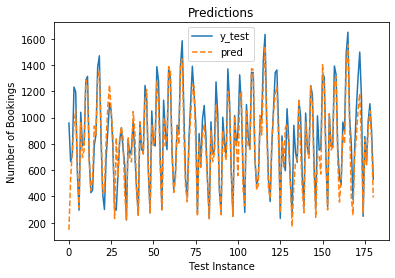

In [82]:
plot_pred(ys, yhats, "charts/NeuralNetPredictionDynamic")

In [ ]:
model.summary()